In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional,
    Dense, Dropout, Input, Concatenate, BatchNormalization, SpatialDropout1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint

from datasets import load_dataset
import plotly.express as px

## تحميل مجموعة البيانات

In [3]:
dataset_name = "Ahmed-Selem/Shifaa_Arabic_Medical_Consultations"

try:
    dataset = load_dataset(dataset_name)
    print(f"Successfully downloaded dataset: {dataset_name}")
    print(dataset)
except Exception as e:
    print(f"Error downloading dataset {dataset_name}: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

General_Surgery_and_Cosmetic_Surgery.csv: 0.00B [00:00, ?B/s]

alternative_Medicine.csv: 0.00B [00:00, ?B/s]

Endocrine_and_Hormonal_Diseases.csv: 0.00B [00:00, ?B/s]

pediatrics.csv: 0.00B [00:00, ?B/s]

Bone_Diseases.csv:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

(…)cal_Affairs_and_Miscellaneous_Issues.csv: 0.00B [00:00, ?B/s]

Nervous_System_Diseases.csv:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Pharmaceuticals_and_Preparations.csv:   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Blood_Diseases_and_Oncology.csv:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

Head_Diseases.csv:   0%|          | 0.00/30.4M [00:00<?, ?B/s]

Obstetrics_and_Gynecology.csv:   0%|          | 0.00/56.4M [00:00<?, ?B/s]

Dermatological_Diseases.csv:   0%|          | 0.00/38.3M [00:00<?, ?B/s]

Internal_Medicine_and_Respiratory_Diseas(…):   0%|          | 0.00/47.1M [00:00<?, ?B/s]

Muscular_Diseases.csv: 0.00B [00:00, ?B/s]

Physical_Health.csv:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Urinary_System_Diseases_and_Others.csv:   0%|          | 0.00/22.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/84422 [00:00<?, ? examples/s]

Successfully downloaded dataset: Ahmed-Selem/Shifaa_Arabic_Medical_Consultations
DatasetDict({
    train: Dataset({
        features: ['Question Title', 'Question', 'Answer', 'Doctor Name', 'Consultation Number', 'Date of Answer', 'Hierarchical Diagnosis'],
        num_rows: 84422
    })
})


## تحويل البيانات إلى DataFrame

هذا التحويل يسهل علينا:
- استكشاف البيانات (EDA)
- تنفيذ عمليات المعالجة المسبقة
- تحليل الأعمدة والقيم النصية



In [4]:
df = dataset['train'].to_pandas()
print("Dataset converted to pandas DataFrame. Displaying the first 5 rows:")
display(df.head())

Dataset converted to pandas DataFrame. Displaying the first 5 rows:


,Question Title,Question,Answer,Doctor Name,Consultation Number,Date of Answer,Hierarchical Diagnosis
0,هل ارتفاع اليوزينيات في تحليل الدم تدل على أمر...,السلام عليكم\nالشكر الجزيل لكل من يسهر على هذه...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ مريم حف...,د. عطية إبراهيم محمد,2549588,2024-09-19,أمراض الدم والأورام - أمراض الدم - أخرى
1,هل يوجد إشكال في اختلاف فصيلة الدم بين الزوجين؟,السلام عليكم\n\nتزوجت من قريبتي وكانت زمرة الد...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ مصعب حفظه...,د. كندا تركي العابد,2530722,2023-12-25,أمراض الدم والأورام - أمراض الدم - أخرى
2,اختلاف فصيلة دم الأم والطفل هل يؤثر على حياة ا...,السلام عليكم ورحمة الله وبركاته\n\nإذا كانت فص...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ Zehra ح...,د. حاتم محمد أحمد,2526579,2023-11-29,أمراض الدم والأورام - أمراض الدم - أخرى
3,عملية استئصال الطحال وعلاقتها بمرض الكريات الح...,عندي مرض كثرة الكريات الحمراء الكروية الوراثي،...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ حسام حفظه...,د. محمد مازن,2523308,2023-11-16,أمراض الدم والأورام - أمراض الدم - أخرى
4,ما هي المدة اللازمة لعلاج طفلي من حمى البحر ال...,السلام عليكم ورحمة الله وبركاته.\n\nابني عمره ...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ Ali حفظه ...,د. عطية إبراهيم محمد,2518451,2023-09-13,أمراض الدم والأورام - أمراض الدم - أخرى


In [5]:
# Extract the main category from 'Hierarchical Diagnosis'
df['Main Category'] = df['Hierarchical Diagnosis'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and ' - ' in x else x)

print("Added 'main category' column. Displaying the first 5 rows with the new column:")
display(df.head())

Added 'main category' column. Displaying the first 5 rows with the new column:


,Question Title,Question,Answer,Doctor Name,Consultation Number,Date of Answer,Hierarchical Diagnosis,Main Category
0,هل ارتفاع اليوزينيات في تحليل الدم تدل على أمر...,السلام عليكم\nالشكر الجزيل لكل من يسهر على هذه...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ مريم حف...,د. عطية إبراهيم محمد,2549588,2024-09-19,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام
1,هل يوجد إشكال في اختلاف فصيلة الدم بين الزوجين؟,السلام عليكم\n\nتزوجت من قريبتي وكانت زمرة الد...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ مصعب حفظه...,د. كندا تركي العابد,2530722,2023-12-25,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام
2,اختلاف فصيلة دم الأم والطفل هل يؤثر على حياة ا...,السلام عليكم ورحمة الله وبركاته\n\nإذا كانت فص...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ Zehra ح...,د. حاتم محمد أحمد,2526579,2023-11-29,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام
3,عملية استئصال الطحال وعلاقتها بمرض الكريات الح...,عندي مرض كثرة الكريات الحمراء الكروية الوراثي،...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ حسام حفظه...,د. محمد مازن,2523308,2023-11-16,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام
4,ما هي المدة اللازمة لعلاج طفلي من حمى البحر ال...,السلام عليكم ورحمة الله وبركاته.\n\nابني عمره ...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ Ali حفظه ...,د. عطية إبراهيم محمد,2518451,2023-09-13,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام


## استكشاف بنية مجموعة البيانات
في هذه الخطوة نقوم بفحص البنية العامة لمجموعة البيانات من خلال:
- معرفة عدد الصفوف (العينات)
- عدد الأعمدة (الميزات)
- أسماء الأعمدة المتوفرة



In [6]:
print("Number of rows and columns in the dataset:")
print(df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())


Number of rows and columns in the dataset:
(84422, 8)

Columns in the dataset:
['Question Title', 'Question', 'Answer', 'Doctor Name', 'Consultation Number', 'Date of Answer', 'Hierarchical Diagnosis', 'Main Category']


نلاحظ أن مجموعة البيانات تحتوي على 84,422 عينة و 8 أعمدة  



## التحقق من القيم المفقودة



In [7]:
print("Number of missing values in each column:")
print(df.isnull().sum())

Number of missing values in each column:
Question Title            0
Question                  0
Answer                    0
Doctor Name               0
Consultation Number       0
Date of Answer            0
Hierarchical Diagnosis    0
Main Category             0
dtype: int64


تُظهر النتائج أن جميع الأعمدة خالية من القيم المفقودة  
مما يدل على جودة مجموعة البيانات ويغنينا عن تنفيذ خطوات معالجة خاصة بالقيم الناقصة.


## توزيع الفئات الطبية (Main Category)


In [8]:
print("Distribution of Main Category:")
print(df['Main Category'].value_counts())

Distribution of Main Category:
Main Category
أمراض النساء والولادة            14524
أمراض الباطنية والصدر            11841
الأدوية والمستحضرات              10315
أمراض الجلدية                     9164
أمراض الرأس                       8574
أمراض الجهاز البولي والتناسلي     6510
أمراض العظام                      6005
الصحة البدنية                     5321
أمراض الدم والأورام               2793
أمراض الجهاز العصبي               2368
شئون طبية ومشاكل متفرقة           2159
أمراض الأطفال ومشاكلهم            2047
أمراض الغدد والهرمونات            1226
أمراض العضلات                      738
الجراحة العامة والتجميل            438
الطب البديل                        399
Name: count, dtype: int64


نلاحظ أن بعض التخصصات الطبية تحتوي على عدد كبير من الأسئلة مثل:
- أمراض النساء والولادة
- أمراض الباطنية والصدر

في حين أن تخصصات أخرى تحتوي على عدد أقل من العينات مثل:
- الطب البديل
- الجراحة العامة والتجميل

وهذا يشير إلى وجود عدم توازن نسبي بين الفئات


## التوزيع النسبي للفئات الطبية


In [9]:
print("Percentage distribution of Main Category:")
print(df['Main Category'].value_counts(normalize=True) * 100)


Percentage distribution of Main Category:
Main Category
أمراض النساء والولادة            17.204046
أمراض الباطنية والصدر            14.025965
الأدوية والمستحضرات              12.218379
أمراض الجلدية                    10.854990
أمراض الرأس                      10.156120
أمراض الجهاز البولي والتناسلي     7.711260
أمراض العظام                      7.113075
الصحة البدنية                     6.302859
أمراض الدم والأورام               3.308379
أمراض الجهاز العصبي               2.804956
شئون طبية ومشاكل متفرقة           2.557390
أمراض الأطفال ومشاكلهم            2.424723
أمراض الغدد والهرمونات            1.452228
أمراض العضلات                     0.874180
الجراحة العامة والتجميل           0.518822
الطب البديل                       0.472626
Name: proportion, dtype: float64


نلاحظ أن أكبر فئة تمثل حوالي 17% من البيانات،  
بينما بعض الفئات تمثل أقل من 1% فقط.

هذا التفاوت يؤكد ضرورة الانتباه إلى مشكلة **Class Imbalance** أثناء مرحلة النمذجة.


## تحليل طول نصوص الأسئلة
في هذه الخطوة نقوم بتحليل طول الأسئلة الطبية من حيث:
- عدد المحارف (Character Length)
- عدد الكلمات (Word Length)

In [10]:
df['question_char_length'] = df['Question'].apply(lambda x: len(str(x)))
df['question_word_length'] = df['Question'].apply(lambda x: len(str(x).split()))
print("Added character length and word length for each question.")
display(df[['Question', 'question_char_length', 'question_word_length']].head())


Added character length and word length for each question.


,Question,question_char_length,question_word_length
0,السلام عليكم\nالشكر الجزيل لكل من يسهر على هذه...,263,46
1,السلام عليكم\n\nتزوجت من قريبتي وكانت زمرة الد...,96,18
2,السلام عليكم ورحمة الله وبركاته\n\nإذا كانت فص...,245,44
3,عندي مرض كثرة الكريات الحمراء الكروية الوراثي،...,147,23
4,السلام عليكم ورحمة الله وبركاته.\n\nابني عمره ...,222,39


نلاحظ وجود تباين في أطوال الأسئلة،  
حيث تتراوح الأسئلة بين قصيرة نسبيًا وأخرى أطول تحتوي على شرح تفصيلي للحالة الطبية

## التحليل الإحصائي لأطوال نصوص الأسئلة


In [11]:
print("Character length statistics:")
display(df['question_char_length'].describe())
print("Word length statistics:")
display(df['question_word_length'].describe())


Character length statistics:


,question_char_length
count,84422.000000
mean,586.600294
std,443.939568
min,14.000000
25%,284.000000
50%,465.000000
75%,752.000000
max,6978.000000


Word length statistics:


,question_word_length
count,84422.000000
mean,104.823091
std,79.468904
min,3.000000
25%,51.000000
50%,83.000000
75%,134.000000
max,1277.000000


نلاحظ أن:
- متوسط طول السؤال يقارب 587 محرفًا و 105 كلمة
- نصف الأسئلة تقريبًا تحتوي على أقل من 465 محرفًا و 83 كلمة
- توجد أسئلة طويلة جدًا تصل إلى أكثر من 1200 كلمة وقرابة 7000 محرف

يشير ذلك إلى وجود تفاوت كبير في أطوال الأسئلة


## التحقق من الأسئلة المكررة


In [12]:
duplicate_count = df['Question'].duplicated().sum()
print(f"Number of duplicated questions: {duplicate_count}")


Number of duplicated questions: 29212


تم العثور على 29,212 سؤالا مكررا،  
وهو عدد كبير نسبيا مقارنة بحجم البيانات الكلي.

## تحليل الأسئلة المتطرفة (قصيرة جدًا وطويلة جدًا)
لفهم طبيعة البيانات بشكل أعمق، نقوم بعرض أمثلة على:
- الأسئلة القصيرة جدًا (أقل من 3 كلمات)
- الأسئلة الطويلة جدًا (أكثر من 50 كلمة)

In [13]:
print("Examples of very short questions (less than 3 words):")
display(df[df['question_word_length'] < 3].head())
print("\nExamples of very long questions (more than 50 words):")
display(df[df['question_word_length'] > 50].head())

Examples of very short questions (less than 3 words):


,Question Title,Question,Answer,Doctor Name,Consultation Number,Date of Answer,Hierarchical Diagnosis,Main Category,question_char_length,question_word_length



Examples of very long questions (more than 50 words):


,Question Title,Question,Answer,Doctor Name,Consultation Number,Date of Answer,Hierarchical Diagnosis,Main Category,question_char_length,question_word_length
5,هل تسبب زيادة الهيموغلوبين في الدم حدوث تخثر و...,السلام عليكم ورحمة الله وبركاته.\n\nلدي استشار...,بسم الله الرحمن الرحيم\nالأخ الفاضل/ محمد حفظه...,د. محمد مازن,2510199,2023-06-12,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام,888,157
6,هل يمكن علمياً اعتماد فصائل الدم كإثبات للنسب؟,السلام عليكم.\n\nقرأت موضوعًا عن فصائل الدم، و...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ سميرة ح...,د. حاتم محمد أحمد,2505561,2023-05-25,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام,335,68
7,ألم الصدر ودقات القلب السريعة هل سببه فقر الدم...,السلام عليكم\n\nمنذ أربعة أشهر كنت أشعر بتعب، ...,بسم الله الرحمن الرحيم.\nالأخت الفاضلة/ فاطمة ...,د. عطية إبراهيم محمد,2397935,2019-02-18,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام,546,99
8,هل يؤدي الضغط على الإبرة في الذراع إلى دخول ال...,السلام عليكم\n\nقمت بعمل تحليل، وأثناء سحب الع...,بسم الله الرحمن الرحيم\nالأخت الفاضلة/ Dear حف...,د. كندا تركي العابد,2389508,2018-12-16,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام,313,58
9,زيادة الهيموجلوبين في الدم ما سببها، وهل لها ع...,السلام عليكم ورحمة الله وبركاته.\n\nمدخن، أدخن...,بسم الله الرحمن الرحيم.\nالأخ الفاضل/ محمد حفظ...,د. عطية إبراهيم محمد,2389217,2018-12-12,أمراض الدم والأورام - أمراض الدم - أخرى,أمراض الدم والأورام,1824,330


نلاحظ أن الأسئلة القصيرة جدا غير موجودة فعليًا،  
بينما الأسئلة الطويلة شائعة نسبيًا، وغالبًا ما تتضمن وصفًا تفصيليًا للحالة الطبية.

In [14]:

fig = px.histogram(
    df,
    x='question_word_length',
    nbins=50,
    title='Distribution of Question Lengths (in words)',
    labels={'question_word_length': 'Number of words in question', 'count': 'Number of questions'},
    color_discrete_sequence=['skyblue']
)

fig.update_layout(
    bargap=0.05,
    xaxis=dict(title='Number of words in question'),
    yaxis=dict(title='Number of questions'),
    template='plotly_white'
)

fig.show()


#عدد الفئات داخل Hierarchical Diagnosis



In [15]:
print("Number of unique hierarchical diagnoses:")
print(df['Hierarchical Diagnosis'].nunique())
print("\nExamples of diagnosis values:")
display(df['Hierarchical Diagnosis'].head(10))


Number of unique hierarchical diagnoses:
585

Examples of diagnosis values:


,Hierarchical Diagnosis
0,أمراض الدم والأورام - أمراض الدم - أخرى
1,أمراض الدم والأورام - أمراض الدم - أخرى
2,أمراض الدم والأورام - أمراض الدم - أخرى
3,أمراض الدم والأورام - أمراض الدم - أخرى
4,أمراض الدم والأورام - أمراض الدم - أخرى
5,أمراض الدم والأورام - أمراض الدم - أخرى
6,أمراض الدم والأورام - أمراض الدم - أخرى
7,أمراض الدم والأورام - أمراض الدم - أخرى
8,أمراض الدم والأورام - أمراض الدم - أخرى
9,أمراض الدم والأورام - أمراض الدم - أخرى


نلاحظ وجود 585 تصنيفا هرميا مختلفا  
مما يعكس درجة عالية من التفصيل في التشخيص الطبي.


## تحليل التصنيفات الطبية الرئيسية (Main Category)

In [16]:
print("Number of unique Main Category:")
print(df['Main Category'].nunique())
print("All unique Main Categories:")
display(df['Main Category'].unique())


Number of unique Main Category:
16
All unique Main Categories:


array(['أمراض الدم والأورام', 'أمراض العظام', 'أمراض الجلدية',
       'أمراض الغدد والهرمونات', 'الجراحة العامة والتجميل', 'أمراض الرأس',
       'أمراض الباطنية والصدر', 'شئون طبية ومشاكل متفرقة',
       'أمراض العضلات', 'أمراض الجهاز العصبي', 'أمراض النساء والولادة',
       'الأدوية والمستحضرات', 'الصحة البدنية',
       'أمراض الجهاز البولي والتناسلي', 'الطب البديل',
       'أمراض الأطفال ومشاكلهم'], dtype=object)

نلاحظ أن عدد الفئات الطبية الرئيسية هو 16 فئة فقط  
وهو عدد مناسب لبناء نماذج تصنيف فعالة ومستقرة.



In [17]:
category_counts = df['Main Category'].value_counts().reset_index()
category_counts.columns = ['Main Category', 'Count']
fig = px.bar(
    category_counts,
    x='Main Category',
    y='Count',
    title='Distribution of Main Categories',
    text='Count',
    color='Count',
    color_continuous_scale='Viridis')
fig.update_layout(
    xaxis_title="Main Category",
    yaxis_title="Number of Questions",
    xaxis_tickangle=-45)
fig.show()

## إزالة الأسئلة المكررة
الهدف من هذه الخطوة هو:
- تقليل التحيز في البيانات
- منع تكرار نفس العينة في التدريب والتقييم
- تحسين تعميم النموذج

In [18]:
def remove_duplicates(df):
    before = len(df)
    df = df.drop_duplicates(subset='Question', keep='first')
    after = len(df)
    print(f"Removed {before - after} duplicated questions.")
    return df

df = remove_duplicates(df)


Removed 29212 duplicated questions.


تمت إزالة 29,212 سؤالا مكررا

In [19]:
category_counts_cleaned = df['Main Category'].value_counts().reset_index()
category_counts_cleaned.columns = ['Main Category', 'Count']
fig = px.bar(
    category_counts_cleaned,
    x='Main Category',
    y='Count',
    title='Distribution of Main Categories (After Removing Duplicates)',
    text='Count',
    color='Count',
    color_continuous_scale='Viridis')
fig.update_layout(
    xaxis_title="Main Category",
    yaxis_title="Number of Questions",
    xaxis_tickangle=-45)
fig.show()


## تنظيف النصوص الطبية

في هذه الخطوة نقوم بتنظيف نصوص الأسئلة الطبية من العناصر غير المفيدة، مثل:
- الروابط الإلكترونية
- الرموز الخاصة غير العربية
- التكرار غير الضروري للفراغات

يهدف هذا التنظيف إلى تقليل الضجيج وتحسين جودة تمثيل النص.


In [20]:
def clean_medical_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r"http\S+|www.\S+", " ", text)
    text = re.sub(r"[^\w\s\u0600-\u06FF0-9]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_question'] = df['Question'].apply(clean_medical_text)

## توحيد الكتابة العربية (Normalization)

نقوم بتوحيد هذه الأشكال إلى صيغة واحدة.

تشمل هذه الخطوة:
- توحيد الألف(أ, إ, آ → ا)
- تحويل (ى → ي)
- تحويل (ة → ه)
- إزالة التطويل (ـ)

يساعد ذلك في:
- تقليل حجم المفردات
- تحسين تمثيل الكلمات
- زيادة كفاءة النماذج الإحصائية والعميقة


In [21]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ـ", "", text)
    return text

df['normalized_question'] = df['clean_question'].apply(normalize_arabic)
df[['clean_question','normalized_question']].head()


,clean_question,normalized_question
0,السلام عليكم الشكر الجزيل لكل من يسهر على هذه ...,السلام عليكم الشكر الجزيل لكل من يسهر علي هذه ...
1,السلام عليكم تزوجت من قريبتي وكانت زمرة الدم ل...,السلام عليكم تزوجت من قريبتي وكانت زمره الدم ل...
2,السلام عليكم ورحمة الله وبركاته إذا كانت فصيلة...,السلام عليكم ورحمه الله وبركاته اذا كانت فصيله...
3,عندي مرض كثرة الكريات الحمراء الكروية الوراثي،...,عندي مرض كثره الكريات الحمراء الكرويه الوراثي،...
4,السلام عليكم ورحمة الله وبركاته ابني عمره 10 س...,السلام عليكم ورحمه الله وبركاته ابني عمره 10 س...


## إزالة كلمات التوقف

كلمات التوقف هي كلمات شائعة في اللغة (مثل: من، إلى، على)  
ولا تحمل غالبًا قيمة دلالية مهمة لعملية التصنيف.

In [22]:
  nltk.download('stopwords')
  arabic_stopwords = set(stopwords.words('arabic'))
  def remove_stopwords(text):
      words = text.split()
      words = [w for w in words if w not in arabic_stopwords]
      return " ".join(words)
  df['no_stopwords_question'] = df['normalized_question'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## إزالة الأسئلة القصيرة جدًا

بعض الأسئلة القصيرة جدًا (أقل من 3 كلمات)  
لا تحتوي على معلومات كافية لتحديد الاختصاص الطبي بدقة.

لذلك نقوم بحذف هذه الأسئلة من مجموعة البيانات.


In [23]:
before = len(df)
df = df[df['no_stopwords_question'].apply(lambda x: len(x.split()) >= 3)]
after = len(df)
print(f"Removed {before - after} very short questions.")


Removed 1 very short questions.


تمت إزالة سؤال واحد فقط  
مما يدل على أن معظم الأسئلة تحتوي على وصف كافٍ للحالة الطبية.


## قص النصوص الطويلة

نظرًا لوجود أسئلة طويلة جدًا،  
نقوم بتحديد حد أقصى لطول السؤال بـ 250 كلمة.

In [24]:
def trim_text(text, max_words=250):
    words = text.split()
    if len(words) > max_words:
        return " ".join(words[:max_words])
    return text
df['trimmed_question'] = df['no_stopwords_question'].apply(trim_text)


## 🏷️ ترميز الفئات (Label Encoding)

بما أن عمود(Main Category) عبارة عن نص عربي،
فإننا نحتاج لتحويله إلى أرقام حتى تتمكن النماذج من التعامل معه.

In [25]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Main Category'])
df[['Main Category','label']].head()


,Main Category,label
0,أمراض الدم والأورام,5
1,أمراض الدم والأورام,5
2,أمراض الدم والأورام,5
3,أمراض الدم والأورام,5
4,أمراض الدم والأورام,5


## تقسيم البيانات إلى تدريب وتحقق واختبار

في هذه الخطوة نقوم بتقسيم البيانات إلى:
- 80% تدريب
- 10% تحقق (Validation)
- 10% اختبار (Test)

يتم التقسيم باستخدام **Stratified Sampling**  
لضمان الحفاظ على نفس توزيع الفئات في جميع المجموعات.


In [26]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
print(train_df.shape, val_df.shape, test_df.shape)


(44167, 15) (5521, 15) (5521, 15)


## تحديد المدخلات والمخرجات

- المدخلات (X): نص السؤال بعد المعالجة (`trimmed_question`)
- المخرجات (y): التصنيف الطبي المرمّز (`label`)


In [27]:
X_train = train_df['trimmed_question']
X_val = val_df['trimmed_question']
X_test = test_df['trimmed_question']

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']


### تحويل النصوص إلى TF-IDF Features


In [89]:
tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.90,
    max_features=50000,
    token_pattern=r"(?u)\b\w+\b",
    lowercase=False,
    stop_words=None
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_val_tfidf shape:  ", X_val_tfidf.shape)
print("X_test_tfidf shape: ", X_test_tfidf.shape)

X_train_tfidf shape: (44167, 50000)
X_val_tfidf shape:   (5521, 50000)
X_test_tfidf shape:  (5521, 50000)


###  تحليل بعض ميزات TF-IDF


In [90]:
feature_names = tfidf.get_feature_names_out()
print("Number of features:", len(feature_names))
print(feature_names[:20])
row0 = X_train_tfidf[0]
nz = row0.nonzero()[1]
top_n = sorted([(i, row0[0, i]) for i in nz], key=lambda x: x[1], reverse=True)[:15]
for idx, val in top_n:
    print(feature_names[idx], "-->", val)


Number of features: 50000
['0' '0 05' '0 1' '0 25' '0 3' '0 4' '0 5' '0 50' '0 6' '0 75' '0 9' '00'
 '000' '01' '02' '03' '04' '05' '06' '07']
بدات اقلق --> 0.268672155513884
شرب اللبن --> 0.26077854132004935
اعاني مغص --> 0.24943049989559024
ذلك فما --> 0.2482764382491911
ذلك وقد --> 0.24716593664058162
مغص شديد --> 0.23213499474816124
ذلك --> 0.23086716487642986
باسهال --> 0.22086552426532208
فما الاسباب --> 0.21749902254646572
مصحوب --> 0.21412177596710902
وبعد اعاني --> 0.21141413826195302
اقلق --> 0.20137525690727917
وقد بدات --> 0.20024773198309329
اللبن --> 0.19372605870241608
اعرف سبب --> 0.18324870088184567


عند استعراض بعض الميزات الأعلى وزنًا في أحد نصوص التدريب، لوحظ وجود:

- عبارات طبية دلالية مثل:
  - `اعاني مغص`
  - `مغص شديد`
  - `شرب اللبن`
- وبعض الكلمات أو العبارات العامة مثل:
  - `ذلك`
  - `وقد`

###  تدريب نموذج Logistic Regression (Baseline)

تم تدريب نموذج **Logistic Regression** بالإعدادات الافتراضية مع:

- `class_weight='balanced'`  
  لمعالجة عدم توازن الفئات.

In [91]:
logreg = LogisticRegression(
    max_iter=300,
    class_weight='balanced',
    solver='liblinear',
    n_jobs=-1
)
logreg.fit(X_train_tfidf, y_train)
train_pred = logreg.predict(X_train_tfidf)
val_pred = logreg.predict(X_val_tfidf)
test_pred = logreg.predict(X_test_tfidf)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, val_pred))

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



Train Accuracy: 0.8288767631942401
Validation Accuracy: 0.7277667089295418
Test Accuracy: 0.7266799492845499

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       132
           1       0.75      0.72      0.74       764
           2       0.81      0.77      0.79       675
           3       0.80      0.80      0.80       408
           4       0.58      0.54      0.56       155
           5       0.51      0.52      0.52       226
           6       0.77      0.71      0.74       557
           7       0.38      0.23      0.28        40
           8       0.75      0.76      0.76       455
           9       0.57      0.59      0.58       102
          10       0.85      0.86      0.85       901
          11       0.76      0.79      0.77       651
          12       0.36      0.41      0.38        34
          13       0.62      0.67      0.64       248
          14       0.33      0.17     

**الاداء العام للنموذج**
| المجموعة | الدقة (Accuracy) |
|--------|------------------|
| Training | 82.9% |
| Validation | 72.8% |
| Test | 72.7% |
**تحليل:**
- الفرق بين دقة التدريب ودقة التحقق/الاختبار يشير إلى Overfitting محدود
- تقارب دقة التحقق والاختبار يدل على أن النموذج يعمّم بشكل جيد ولا يحفظ البيانات فقط.

`Class-wise Performance:`
الفئات ذات العينات الكبيرة (مثل 1، 2، 3، 6، 8، 10، 11) أظهرت:
- Precision وRecall مرتفعين
- قيم F1-score جيدة (0.74 – 0.85)

الفئة 10 هي الأفضل أداء

F1 ≈ 0.85 في كل من Validation وTest
→ يدل على تمييز قوي للسمات النصية الخاصة بها.

`Impact of Class Imbalance:`

بعض الفئات ذات الدعم القليل جدا (مثل 7، 12، 14، 15) سجلت:

- Recall منخفض
- F1-score ضعيف (< 0.30)

رغم استخدام class_weight='balanced'، ما زال النموذج يعاني مع الفئات النادرة.

`Macro vs Weighted Average:`

- Weighted F1 ≈ 0.73
→ يعكس أداء جيدا على الفئات الأكثر شيوعًا.

- Macro F1 ≈ 0.59
→ يكشف التفاوت في الأداء بين الفئات، خاصة الفئات الصغيرة.

الفرق بينهما يؤكد أن عدم توازن البيانات يؤثر على التقييم الكلي.

` Validation vs Test Consistency:`

التشابه الكبير بين تقارير Validation وTest:

يدل على أن عملية التقسيم صحيحة

ولا يوجد تسريب بيانات (Data Leakage)

#Confusion matrix :

Confusion matrix for test data (Shape: (16, 16))


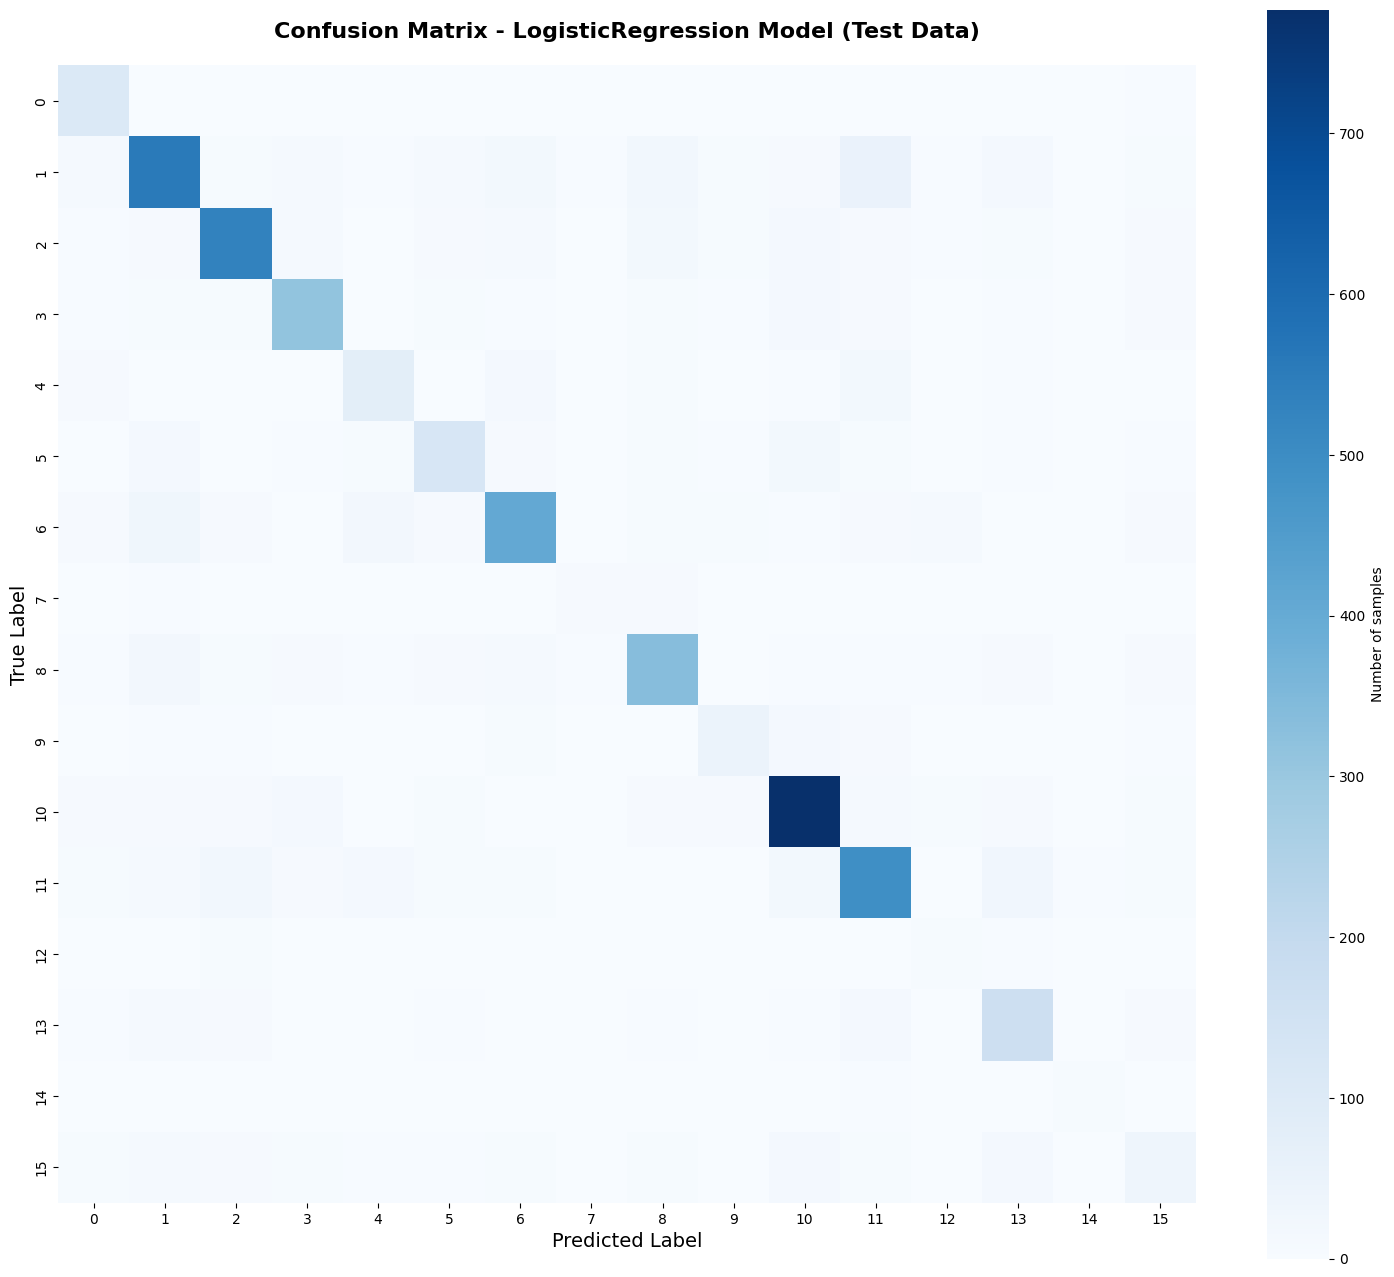

In [97]:

cm_test = confusion_matrix(y_test, test_pred)
print(f"Confusion matrix for test data (Shape: {cm_test.shape})")

plt.figure(figsize=(15, 13))
sns.heatmap(cm_test,
            annot=False,
            fmt='d',
            cmap='Blues',
            cbar_kws={'label': 'Number of samples'},
            square=True)

plt.title('Confusion Matrix - LogisticRegression Model (Test Data)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

In [100]:
def calculate_class_accuracy(cm, class_names):
    class_accuracies = []

    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i, :].sum()
        accuracy = (correct / total * 100) if total > 0 else 0

        class_accuracies.append({
            'Class': class_name,
            'Accuracy_%': accuracy,
            'Correct': correct,
            'Total': total,
            'Errors': total - correct
        })

    accuracy_df = pd.DataFrame(class_accuracies)
    accuracy_df = accuracy_df.sort_values('Accuracy_%')

    return accuracy_df

accuracy_df = calculate_class_accuracy(cm_test, class_names)

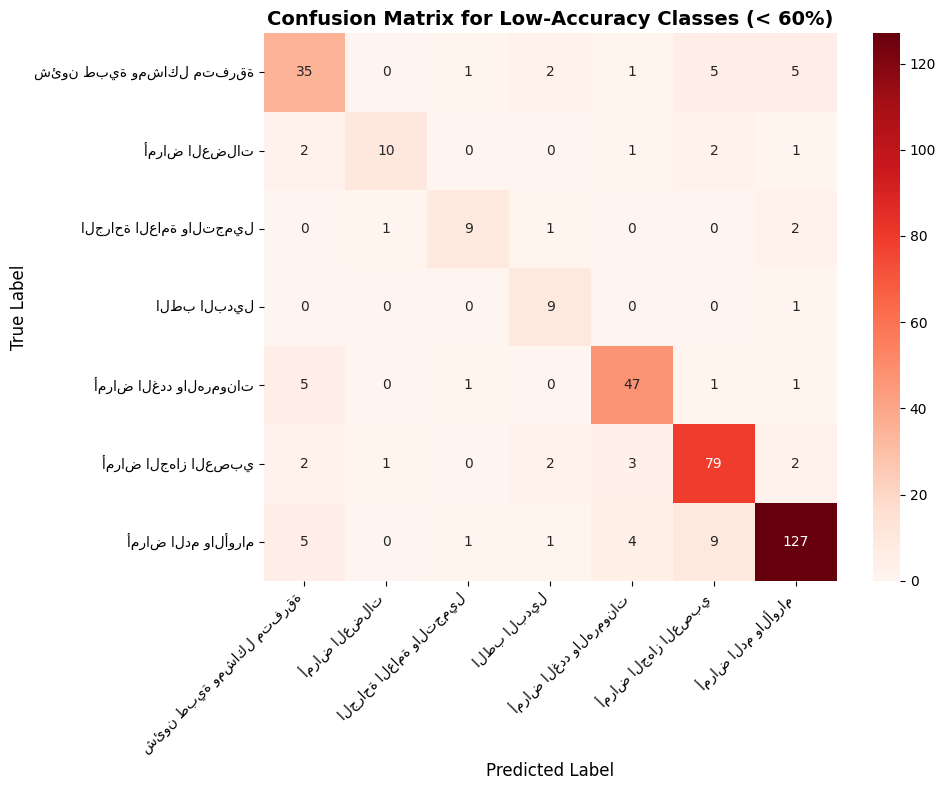

In [101]:
low_accuracy_classes = accuracy_df[accuracy_df['Accuracy_%'] < 60]['Class'].tolist()
low_accuracy_indices = [np.where(class_names == cls)[0][0] for cls in low_accuracy_classes]

if low_accuracy_indices:
    cm_problematic = cm_test[low_accuracy_indices][:, low_accuracy_indices]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_problematic,
                annot=True,
                fmt='d',
                cmap='Reds',
                xticklabels=low_accuracy_classes,
                yticklabels=low_accuracy_classes)

    plt.title('Confusion Matrix for Low-Accuracy Classes (< 60%)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 🔍 Hyperparameter Tuning (Logistic Regression)
في هذه المرحلة قمنا باستخدام `GridSearchCV` لاختيار أفضل معاملات (Hyperparameters)

المعاملات التي تم اختبارها:
- **C**: للتحكم بدرجة التنظيم (Regularization Strength)
- **penalty**: استخدمنا L2
- **solver**: جربنا `lbfgs` و `liblinea

In [103]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs','liblinear']
}
grid = GridSearchCV(
    LogisticRegression(max_iter=3000),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1 )

grid.fit(X_train_tfidf, y_train)
print("Best Params:", grid.best_params_)
best_log_reg = grid.best_estimator_
y_val_pred = best_log_reg.predict(X_val_tfidf)
print("Improved Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Best Params: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}
Improved Validation Accuracy: 0.7384531787719616


النتيجة:
- أفضل إعدادات كانت:
  - `C = 5`
  - `penalty = 'l2'`
  - `solver = 'liblinear'`

###  Training Logistic Regression with Best Parameters

بعد تحديد أفضل المعاملات من خلال GridSearchCV،
قمنا بإعادة تدريب نموذج Logistic Regression باستخدام هذه القيم:

In [104]:
logreg = LogisticRegression(
    C=5,
    penalty='l2',
    max_iter=300,
    class_weight='balanced',
    solver='liblinear',
)
logreg.fit(X_train_tfidf, y_train)
train_pred = logreg.predict(X_train_tfidf)
val_pred = logreg.predict(X_val_tfidf)
test_pred = logreg.predict(X_test_tfidf)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, val_pred))

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))


Train Accuracy: 0.9367174587361605
Validation Accuracy: 0.7371852925194711
Test Accuracy: 0.7373664191269698

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       132
           1       0.74      0.75      0.75       764
           2       0.79      0.80      0.79       675
           3       0.81      0.80      0.81       408
           4       0.57      0.49      0.53       155
           5       0.52      0.52      0.52       226
           6       0.77      0.73      0.74       557
           7       0.43      0.15      0.22        40
           8       0.76      0.78      0.77       455
           9       0.60      0.54      0.57       102
          10       0.85      0.88      0.86       901
          11       0.76      0.81      0.79       651
          12       0.43      0.26      0.33        34
          13       0.63      0.64      0.64       248
          14       0.40      0.09     



- نتائج الاختبار متقاربة جدًا مع نتائج التحقق،
  مما يؤكد قدرة النموذج على التعميم.
- الفئات الرئيسية حافظت على أداء مستقر:
  - الفئات 2، 3، 6، 8، 10، 11
- الفئات النادرة ما زالت تمثل التحدي الأكبر،
  خاصة من حيث Recall وF1-score.

المقاييس العامة:
- **Test Accuracy ≈ 73.7%**
- **Macro F1 ≈ 0.59**
- **Weighted F1 ≈ 0.73**

هذا يؤكد أن تحسين الأداء الإضافي
يتطلب نماذج أعمق أو تمثيلات لغوية أغنى.


###  Linear SVM Baseline

في هذه التجربة استخدمنا نموذج **Linear Support Vector Machine (LinearSVC)**  
مع تمثيل النصوص باستخدام **TF-IDF** ومعالجة عدم توازن الفئات عبر:
- `class_weight = 'balanced'`

In [105]:
svm_clf = LinearSVC(C=1.0, class_weight='balanced')
svm_clf.fit(X_train_tfidf, y_train)
train_pred = svm_clf.predict(X_train_tfidf)
val_pred = svm_clf.predict(X_val_tfidf)
test_pred = svm_clf.predict(X_test_tfidf)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\n--- Validation Report ---")
print(classification_report(y_val, val_pred))

print("\n--- Test Report ---")
print(classification_report(y_test, test_pred))

Train Accuracy: 0.9865510448977743
Validation Accuracy: 0.7346495200144901
Test Accuracy: 0.7279478355370403

--- Validation Report ---
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       132
           1       0.74      0.76      0.75       764
           2       0.78      0.79      0.79       675
           3       0.80      0.82      0.81       408
           4       0.59      0.51      0.54       155
           5       0.50      0.50      0.50       226
           6       0.75      0.72      0.74       557
           7       0.29      0.15      0.20        40
           8       0.75      0.78      0.76       455
           9       0.58      0.52      0.55       102
          10       0.84      0.89      0.87       901
          11       0.77      0.79      0.78       651
          12       0.45      0.26      0.33        34
          13       0.62      0.62      0.62       248
          14       0.25      0.09      0.13        23

نلاحظ:
- دقة تدريب مرتفعة جدًا → تشير إلى ميل النموذج لحفظ بيانات التدريب.
- انخفاض واضح بين التدريب والتحقق/الاختبار → وجود **overfitting**
  - صعوبة في التمييز رغم استخدام `class_weight='balanced'`

###  Linear SVM with Hyperparameter Tuning


In [106]:
param_grid_svm = {
    'C': [0.1, 0.5, 1, 2, 5, 10]}
svm_model = LinearSVC(class_weight='balanced')
grid_svm = GridSearchCV(
    svm_model,
    param_grid_svm,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_svm.fit(X_train_tfidf, y_train)
print("Best Params:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_
val_pred = best_svm.predict(X_val_tfidf)
print("Improved Validation Accuracy:", accuracy_score(y_val, val_pred))


Best Params: {'C': 0.5}
Improved Validation Accuracy: 0.7400833182394494


In [107]:
best_svm = grid_svm.best_estimator_

train_pred = best_svm.predict(X_train_tfidf)
val_pred = best_svm.predict(X_val_tfidf)
test_pred = best_svm.predict(X_test_tfidf)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, val_pred))

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))


Train Accuracy: 0.958294654379967
Validation Accuracy: 0.7400833182394494
Test Accuracy: 0.7379097989494656

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.78      0.65       132
           1       0.76      0.75      0.75       764
           2       0.78      0.80      0.79       675
           3       0.81      0.81      0.81       408
           4       0.58      0.54      0.56       155
           5       0.53      0.52      0.52       226
           6       0.77      0.72      0.74       557
           7       0.35      0.20      0.25        40
           8       0.77      0.79      0.78       455
           9       0.57      0.54      0.55       102
          10       0.85      0.89      0.87       901
          11       0.78      0.79      0.79       651
          12       0.44      0.32      0.37        34
          13       0.63      0.63      0.63       248
          14       0.18      0.09      

- انخفاض دقة التدريب مقارنة بالـ baseline → تقليل overfitting
- تحسن طفيف لكن مستقر في دقة التحقق والاختبار
- تقارب Validation وTest يدل على **تحسن التعميم*

###  Naive Bayes Models Evaluation (TF-IDF Features)

في هذه المرحلة قمنا بتجربة نموذجين من عائلة Naive Bayes:
- Multinomial Naive Bayes (MNB)
- Complement Naive Bayes (CNB)

In [108]:
def evaluate_nb_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val   = model.predict(X_val)
    y_pred_test  = model.predict(X_test)

    print("===== TRAIN =====")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("===== VALIDATION =====")
    print("Accuracy:", accuracy_score(y_val, y_pred_val))
    print(classification_report(y_val, y_pred_val))

    print("===== TEST =====")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))


# Train Multinomial NB
print("\n================ MultinomialNB ================\n")
mnb = MultinomialNB()
evaluate_nb_model(mnb,
                  X_train_tfidf, y_train,
                  X_val_tfidf, y_val,
                  X_test_tfidf, y_test)


# Train Complement NB
print("\n================ ComplementNB ================\n")
cnb = ComplementNB()
evaluate_nb_model(cnb,
                  X_train_tfidf, y_train,
                  X_val_tfidf, y_val,
                  X_test_tfidf, y_test)



================ MultinomialNB ================

===== TRAIN =====
Accuracy: 0.6892023456426744
              precision    recall  f1-score   support

           0       0.85      0.13      0.22      1056
           1       0.55      0.90      0.69      6114
           2       0.73      0.88      0.80      5396
           3       0.89      0.67      0.76      3263
           4       1.00      0.01      0.02      1237
           5       0.97      0.08      0.14      1811
           6       0.78      0.75      0.76      4457
           7       0.00      0.00      0.00       326
           8       0.82      0.70      0.75      3645
           9       1.00      0.00      0.00       816
          10       0.68      0.95      0.79      7202
          11       0.65      0.84      0.73      5210
          12       0.00      0.00      0.00       272
          13       0.88      0.31      0.46      1984
          14       0.00      0.00      0.00       179
          15       0.00      0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

===== TRAIN =====
Accuracy: 0.7798582652206398
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1056
           1       0.77      0.85      0.81      6114
           2       0.79      0.89      0.84      5396
           3       0.81      0.86      0.84      3263
           4       0.86      0.37      0.51      1237
           5       0.84      0.47      0.60      1811
           6       0.80      0.81      0.81      4457
           7       1.00      0.03      0.07       326
           8       0.77      0.81      0.79      3645
           9       0.89      0.29      0.44       816
          10       0.78      0.94      0.86      7202
          11       0.73      0.83      0.78      5210
          12       1.00      0.06      0.11       272
          13       0.77      0.70      0.73      1984
          14       0.95      0.22      0.36       179
          15       0.94      0.15      0.26      1199

    accuracy                     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

##  Multinomial Naive Bayes

**Performance Insights**
- النموذج يميل بشدة إلى الفئات الأكثر تكرارًا.
- العديد من الفئات (مثل 7، 12، 14، 15) حصلت على:
  - Recall = 0
  - F1-score = 0
- يظهر النموذج ضعفًا واضحًا في التعامل مع عدم توازن البيانات.
- MultinomialNB غير مناسب لهذا التصنيف متعدد الفئات مع عدم توازن كبير.
- لا يُنصح بالاعتماد عليه كنموذج نهائي.
##Complement Naive Bayes

 **Performance Insights**
- تحسن واضح مقارنة بـ MultinomialNB، خاصة مع الفئات غير المتوازنة.
- الفئات الكبيرة (1، 2، 3، 6، 8، 10، 11):
  - حققت F1-score بين **0.73 – 0.84**
- ما زالت الفئات النادرة تعاني من:
  - Recall منخفض جدًا
  - بعض الفئات لم يتم التنبؤ بها إطلاقًا.


### الخلاصة
- ComplementNB يتفوق بوضوح على MultinomialNB.
- مناسب كنموذج baseline سريع.
- لكنه لا يصل لأداء Logistic Regression أو SVM.

###  Complement Naive Bayes with Hyperparameter Tuning


In [111]:
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 1, 2, 3, 5],
    'norm': [True, False]
}

cnb_grid = GridSearchCV(
    ComplementNB(),
    param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

cnb_grid.fit(X_train_tfidf, y_train)

print("Best Params:", cnb_grid.best_params_)

best_cnb = cnb_grid.best_estimator_

train_pred = best_cnb.predict(X_train_tfidf)
val_pred   = best_cnb.predict(X_val_tfidf)
test_pred  = best_cnb.predict(X_test_tfidf)

print("\n===== ACCURACY =====")
print("Train:", accuracy_score(y_train, train_pred))
print("Validation:", accuracy_score(y_val, val_pred))
print("Test:", accuracy_score(y_test, test_pred))

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, val_pred))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Params: {'alpha': 0.1, 'norm': True}

===== ACCURACY =====
Train: 0.7987864242534018
Validation: 0.7308458612570187
Test: 0.7272233291070458

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.57      0.74      0.65       132
           1       0.74      0.78      0.76       764
           2       0.75      0.84      0.79       674
           3       0.78      0.80      0.79       408
           4       0.68      0.25      0.37       154
           5       0.66      0.41      0.51       227
           6       0.71      0.77      0.74       557
           7       0.50      0.02      0.05        41
           8       0.70      0.75      0.73       456
           9       0.65      0.22      0.32       102
          10       0.78      0.91      0.84       900
          11       0.71      0.79      0.75       652
          12       0.00      0.00      0.00        34


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



- تحسن طفيف في Validation و Test مقارنة بالإعداد الافتراضي.
- الفجوة الصغيرة بين Train و Validation تشير إلى:
  - عدم وجود overfitting حاد
- ما زال النموذج يعاني مع الفئات النادرة.

###  Random Forest Classifier with Randomized Search

In [112]:
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train_tfidf, y_train)
print("Best Params:", random_search.best_params_)
best_rf = random_search.best_estimator_

train_pred = best_rf.predict(X_train_tfidf)
val_pred = best_rf.predict(X_val_tfidf)
test_pred = best_rf.predict(X_test_tfidf)

print("\n===== ACCURACY =====")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, val_pred))


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Params: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}

===== ACCURACY =====
Train Accuracy: 0.6316254216949306
Validation Accuracy: 0.6113023003079152
Test Accuracy: 0.598804564390509

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       132
           1       0.76      0.51      0.61       764
           2       0.76      0.62      0.69       674
           3       0.67      0.73      0.70       408
           4       0.42      0.40      0.41       154
           5       0.46      0.39      0.42       227
           6       0.72      0.50      0.59       557
           7       0.22      0.39      0.28        41
           8       0.62      0.56      0.59       456
           9       0.33      0.50      0.40       102
          10       0.75      0.85      0.80       900
 

- الأداء العام للنموذج منخفض مقارنة بنماذج خطية مثل:
  - Logistic Regression
  - Linear SVM
- الفجوة الصغيرة بين Train و Validation تشير إلى:
  - عدم وجود overfitting
  - لكن النموذج يعاني من underfitting
- Random Forest غير مناسب بشكل جيد لبيانات نصية عالية الأبعاد ومتناثرة مثل TF-IDF.

## الطريقة الثانية: Embedding + Deep Learning

تعتمد هذه الطريقة على تمثيل النصوص باستخدام Embedding Layer، حيث يتم تحويل كل كلمة إلى متجه عددي كثيف يعكس معناها وسياقها. بعد ذلك يتم تمرير تسلسل المتجهات إلى نموذج تعلم عميق مثل LSTM أو BiLSTM لاستخلاص العلاقات الزمنية بين الكلمات، ثم تصنيف النص باستخدام طبقة Softmax. تمتاز هذه الطريقة بقدرتها على فهم ترتيب الكلمات والعلاقات الدلالية بينها مقارنةً بالطرق التقليدية مثل TF-IDF.


###  تحضير البيانات النصية

في هذه المرحلة قمنا باستخراج النصوص من عمود `trimmed_question`
وتحويلها إلى نوع `string` لضمان التوافق مع أدوات المعالجة النصية.

بعد ذلك تم تحويل الوسوم (labels) من قيم نصية إلى قيم رقمية باستخدام
`LabelEncoder`

In [113]:
X_train_text = train_df['trimmed_question'].astype(str)
X_val_text   = val_df['trimmed_question'].astype(str)
X_test_text  = test_df['trimmed_question'].astype(str)

y_train = train_df['label']
y_val   = val_df['label']
y_test  = test_df['label']

In [114]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

Number of classes: 16


## Tokenization وتحويل النصوص إلى تسلسلات رقمية
تم استخدام `Tokenizer` لتحويل الكلمات إلى أرقام، مع تحديد:
- `max_words = 50000` لتحديد حجم القاموس
- استخدام رمز `<OOV>` للتعامل مع الكلمات غير المعروفة

بعد التدريب على بيانات التدريب فقط، ثم تحويل:
- بيانات التدريب
- بيانات التحقق
- بيانات الاختبار  
إلى تسلسلات رقمية تمثل كل كلمة برقم فريد.

In [115]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)


## Padding وتوحيد أطوال الجمل

نظرًا لاختلاف أطوال الأسئلة النصية، قمنا بتوحيد الطول باستخدام
`pad_sequences` بحيث يصبح طول كل تسلسل `100` كلمة.

تم اعتماد:
- `padding='post'` لإضافة الحشو في نهاية الجملة
- هذا يسهل على نموذج LSTM معالجة البيانات على دفعات ثابتة الشكل

In [116]:
max_len = 80
X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

X_val_pad = pad_sequences(
    X_val_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

##بناء نموذج LSTM


In [117]:
lengths = [len(seq) for seq in X_train_seq]
np.percentile(lengths, [50, 75, 90, 95, 99])
max_len = 80


In [118]:
num_classes = df['label'].nunique()
embedding_dim = 128


In [119]:
model_lstm = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        input_length=max_len
    ),

    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [120]:
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### معالجة عدم توازن الفئات باستخدام Class Weights


In [121]:
classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights_dict = dict(zip(classes, class_weights))

In [122]:
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weights_dict
)


Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 182s 257ms/step - accuracy: 0.0931 - loss: 2.7157 - val_accuracy: 0.1232 - val_loss: 2.6543
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 179s 259ms/step - accuracy: 0.1397 - loss: 2.6453 - val_accuracy: 0.1833 - val_loss: 2.5065
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 180s 260ms/step - accuracy: 0.1056 - loss: 2.6309 - val_accuracy: 0.1895 - val_loss: 2.4651
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 202s 260ms/step - accuracy: 0.2366 - loss: 2.3023 - val_accuracy: 0.2909 - val_loss: 2.2879
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 175s 253ms/step - accuracy: 0.3557 - loss: 1.9948 - val_accuracy: 0.4729 - val_loss: 1.8767
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 176s 254ms/step - accuracy: 0.5093 - loss: 1.5504 - val_accuracy: 0.4805 - val_loss: 1.7682
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 176s 254ms/step - accuracy: 0.6375 - loss: 1.1373 - val_accuracy: 0.5381 - val_loss: 1.6985
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 178s 257ms/step - accuracy: 0.7476 -

نلاحظ تحسنا تدريجيا في Training Accuracy من قيم منخفضة جدا في البداية إلى أكثر من 91% في نهاية التدريب.

Validation Accuracy ارتفعت تدريجيا أيضا، حيث وصلت إلى حوالي 60%.

بعد عدة عصور، بدأ Validation Loss بالازدياد رغم تحسن دقة التدريب، مما يشير إلى بداية حدوث Overfitting.

In [123]:
test_loss, test_acc = model_lstm.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_acc)

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))

173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5872 - loss: 2.0819
Test Accuracy: 0.5861257314682007

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       132
           1       0.76      0.51      0.61       764
           2       0.76      0.62      0.69       674
           3       0.67      0.73      0.70       408
           4       0.42      0.40      0.41       154
           5       0.46      0.39      0.42       227
           6       0.72      0.50      0.59       557
           7       0.22      0.39      0.28        41
           8       0.62      0.56      0.59       456
           9       0.33      0.50      0.40       102
          10       0.75      0.85      0.80       900
          11       0.70      0.61      0.65       652
          12       0.08      0.26      0.12        34
          13       0.47      0.52      0.49       248
          14       0.12      0.50      0.

# بناء نموذج BiLSTM

في هالخلية عم نبني نموذج BiLSTM لتصنيف النصوص.

النموذج بيستخدم Embedding Layer لتمثيل الكلمات، يلي بعدها يمررها Bidirectional LSTM لاستخلاص العلاقات الزمنية بين الكلمات، ومن ثم طبقات Dense وDropout لتقليل الإفراط في التعلم وتصنيف النصوص.

In [124]:
model_bilstm = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        input_length=max_len
    ),

    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [125]:
model_bilstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

تدريب نموذج BiLSTM

In [126]:
history_bilstm = model_bilstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weights_dict
)


Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 322s 458ms/step - accuracy: 0.1717 - loss: 2.6330 - val_accuracy: 0.3905 - val_loss: 2.0127
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 308s 446ms/step - accuracy: 0.4630 - loss: 1.8437 - val_accuracy: 0.5119 - val_loss: 1.6459
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 316s 457ms/step - accuracy: 0.5927 - loss: 1.3608 - val_accuracy: 0.6084 - val_loss: 1.4726
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 307s 445ms/step - accuracy: 0.7269 - loss: 0.9295 - val_accuracy: 0.6073 - val_loss: 1.5090
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 306s 443ms/step - accuracy: 0.8057 - loss: 0.6622 - val_accuracy: 0.6258 - val_loss: 1.6016
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 328s 474ms/step - accuracy: 0.8728 - loss: 0.4302 - val_accuracy: 0.6361 - val_loss: 1.6046
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 370s 457ms/step - accuracy: 0.9065 - loss: 0.3093 - val_accuracy: 0.6410 - val_loss: 1.7605
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 306s 443ms/step - accuracy: 0.9379 -

النموذج بدأ بدقة منخفضة جدا في البداية (≈18%) على التدريب ودقة منخفضة على التحقق (≈39%).

مع تقدم التدريب، يتحسن الأداء على كل من التدريب والتحقق، مما يدل على أن النموذج يتعلم التمثيل المناسب للنصوص.

على الرغم من تحسن الدقة التدريبية بشكل كبير (>96%)، دقة التحقق تصل إلى حوالي 64%، مما يشير إلى بعض الإفراط في التعلّم (overfitting).

In [127]:
test_loss, test_acc = model_bilstm.evaluate(X_test_pad, y_test)
print("BiLSTM Test Accuracy:", test_acc)

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))

173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6416 - loss: 2.2450
BiLSTM Test Accuracy: 0.6411882042884827

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       132
           1       0.76      0.51      0.61       764
           2       0.76      0.62      0.69       674
           3       0.67      0.73      0.70       408
           4       0.42      0.40      0.41       154
           5       0.46      0.39      0.42       227
           6       0.72      0.50      0.59       557
           7       0.22      0.39      0.28        41
           8       0.62      0.56      0.59       456
           9       0.33      0.50      0.40       102
          10       0.75      0.85      0.80       900
          11       0.70      0.61      0.65       652
          12       0.08      0.26      0.12        34
          13       0.47      0.52      0.49       248
          14       0.12      0.50  

دقة النموذج على مجموعة الاختبار حوالي 64.5%، وهو قريب من دقة التحقق مما يدل على ثبات أداء النموذج.

قيمة الخسارة على الاختبار مرتفعة نسبيًا (≈2.17)، مما يشير إلى أن النموذج يواجه صعوبة في بعض العينات

# بناء نموذج BiLSTM محسّن (BiLSTM Regularized)

هالخلية عم نبني نسخة محسّنة من نموذج BiLSTM لتقليل الإفراط في التعلم. التعديلات تشمل:

زيادة أبعاد الـ Embedding إلى 300

إضافة Dropout إضافية قبل وبعد الـ LSTM وDense layer لمقاومة الإفراط في التعلم.

طبقة Dense أكبر (128 وحدة) لتقوية قدرة النموذج على استخراج الميزات.

In [128]:
model_bilstm_reg = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=300,
        input_length=max_len
    ),

    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [129]:
model_bilstm_reg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## إعداد Early Stopping

هنا نضيف EarlyStopping لإيقاف التدريب تلقائيا إذا لم يتحسن النموذج على بيانات التحقق لمدة معينة(3 epochs)، واستعادة أفضل الأوزان لتقليل الإفراط في التعلم.

In [130]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

In [131]:
history_bilstm_reg = model_bilstm_reg.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping])

Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 560s 802ms/step - accuracy: 0.3325 - loss: 2.0749 - val_accuracy: 0.6718 - val_loss: 1.2411
Epoch 2/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 565s 817ms/step - accuracy: 0.7267 - loss: 1.0527 - val_accuracy: 0.6977 - val_loss: 1.1334
Epoch 3/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 558s 807ms/step - accuracy: 0.8169 - loss: 0.7015 - val_accuracy: 0.6926 - val_loss: 1.2281
Epoch 4/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 553s 794ms/step - accuracy: 0.8731 - loss: 0.4817 - val_accuracy: 0.6798 - val_loss: 1.3870
Epoch 5/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 547s 791ms/step - accuracy: 0.9118 - loss: 0.3314 - val_accuracy: 0.6644 - val_loss: 1.5654


النموذج بدأ بدقة منخفضة على الـ training (33%) ولكنه تحسن بسرعة خلال الـ epochs الأولى.

دقة التحقق (val_accuracy) وصلت إلى حوالي 69-70% في أول 3 epochs، وهذا يدل على أن النموذج تعلم تمثيلات قوية بسرعة.

بعد الـ epoch الثالث، الدقة على التحقق لم تتحسن، مما أدى إلى توقف التدريب مبكرًا بواسطة EarlyStopping.

هذا يوضح أن الـ BiLSTM المحسّن مع Dropout وEmbedding أكبر قادر على تعلم ميزات جيدة بسرعة مع مقاومة الإفراط في التعلم.

In [132]:
test_loss, test_acc = model_bilstm_reg.evaluate(X_test_pad, y_test)
print("Improved BiLSTM Test Accuracy:", test_acc)


173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.6954 - loss: 1.1688
Improved BiLSTM Test Accuracy: 0.6976996660232544


- دقة الاختبار بلغت حوالي 69.6% وهي أفضل من نماذج LSTM وBiLSTM السابقة بدون تحسينات.

- هذا يشير إلى أن التعديلات (زيادة حجم الـ Embedding، Dropout إضافية، Dense أكبر، واستخدام EarlyStopping) ساعدت على تحسين قدرة النموذج على التعميم وتقليل الإفراط في التعلم.

- الأداء المتوازن بين التدريب والتحقق يشير إلى أن النموذج تعلم تمثيلات جيدة للنصوص ولم يبالغ في حفظ بيانات التدريب فقط.

In [133]:
test_pred_prob = model_bilstm_reg.predict(X_test_pad)
test_pred = np.argmax(test_pred_prob, axis=1)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_pred))

173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       132
           1       0.72      0.76      0.74       764
           2       0.73      0.83      0.77       674
           3       0.80      0.78      0.79       408
           4       0.52      0.23      0.32       154
           5       0.39      0.45      0.42       227
           6       0.66      0.79      0.72       557
           7       0.00      0.00      0.00        41
           8       0.65      0.77      0.71       456
           9       0.44      0.04      0.07       102
          10       0.78      0.87      0.82       900
          11       0.72      0.73      0.73       652
          12       0.00      0.00      0.00        34
          13       0.58      0.50      0.54       248
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## تدريب نموذج BiLSTM مع استخدام أوزان الفئات (Class Weights)

In [134]:
history_bilstm = model_bilstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 303s 438ms/step - accuracy: 0.9700 - loss: 0.0885 - val_accuracy: 0.6296 - val_loss: 2.4191
Epoch 2/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 303s 439ms/step - accuracy: 0.9669 - loss: 0.1104 - val_accuracy: 0.6481 - val_loss: 2.4723
Epoch 3/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 303s 438ms/step - accuracy: 0.9777 - loss: 0.0723 - val_accuracy: 0.6472 - val_loss: 2.5743
Epoch 4/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 305s 441ms/step - accuracy: 0.9765 - loss: 0.0759 - val_accuracy: 0.6281 - val_loss: 2.3066
Epoch 5/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 324s 443ms/step - accuracy: 0.9779 - loss: 0.0731 - val_accuracy: 0.6472 - val_loss: 2.7125
Epoch 6/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 318s 438ms/step - accuracy: 0.9865 - loss: 0.0397 - val_accuracy: 0.6441 - val_loss: 2.9386
Epoch 7/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 302s 437ms/step - accuracy: 0.9861 - loss: 0.0492 - val_accuracy: 0.6252 - val_loss: 3.0374


- نلاحظ أن دقة التدريب مرتفعة جدًا منذ البداية (≈97%)، ما يدل على أن النموذج قادر على حفظ بيانات التدريب بسرعة.

- بالمقابل، دقة التحقق (val_accuracy) بقيت بحدود 64–65% ولم تتحسن بشكل واضح.

- ارتفاع val_loss مع كل epoch يشير إلى overfitting واضح رغم استخدام class weights وEarlyStopping.


In [135]:
test_loss, test_acc = model_bilstm.evaluate(X_test_pad, y_test)
print("Improved BiLSTM with class-weight Test Accuracy:", test_acc)

print("\n--- Test Classification Report ---")
print(classification_report(y_test, test_pred))

173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.6211 - loss: 2.4214
Improved BiLSTM with class-weight Test Accuracy: 0.6225321292877197

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       132
           1       0.72      0.76      0.74       764
           2       0.73      0.83      0.77       674
           3       0.80      0.78      0.79       408
           4       0.52      0.23      0.32       154
           5       0.39      0.45      0.42       227
           6       0.66      0.79      0.72       557
           7       0.00      0.00      0.00        41
           8       0.65      0.77      0.71       456
           9       0.44      0.04      0.07       102
          10       0.78      0.87      0.82       900
          11       0.72      0.73      0.73       652
          12       0.00      0.00      0.00        34
          13       0.58      0.50      0.54       248
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



دقة الاختبار بلغت حوالي 64.4%، وهي أقل من دقة نموذج BiLSTM المحسّن مع EarlyStopping.

هذا يؤكد أن:

استخدام class_weight بدون تنظيم إضافي قوي قد يؤدي إلى overfitting.

النموذج المحسّن السابق (Embedding أكبر + Dropout أقوى + EarlyStopping) كان أكثر استقرارًا وأفضل في التعميم.

# CNN

في هذه الخلية نقوم ببناء نموذج Convolutional Neural Network (CNN) لمعالجة النصوص.
تعتمد الفكرة على استخدام Embedding Layer لتحويل الكلمات إلى متجهات عددية، ثم تطبيق Conv1D لاستخلاص الأنماط المحلية (n-grams) داخل الجمل، مثل العبارات أو الكلمات المتجاورة المهمة للتصنيف.
بعد ذلك نستخدم Global Max Pooling لاختيار أهم الخصائص المستخرجة، ثم طبقات Fully Connected لإجراء التصنيف النهائي.

In [137]:
MAX_WORDS = 50000
model_cnn = Sequential([
    Embedding(
        input_dim=MAX_WORDS,
        output_dim=128,
        input_length=max_len
    ),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [138]:
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [140]:
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 170s 117ms/step - accuracy: 0.4007 - loss: 1.9610 - val_accuracy: 0.6941 - val_loss: 1.0980
Epoch 2/20
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 179s 100ms/step - accuracy: 0.7561 - loss: 0.8943 - val_accuracy: 0.7178 - val_loss: 1.0173
Epoch 3/20
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.8680 - loss: 0.4706 - val_accuracy: 0.7115 - val_loss: 1.1812
Epoch 4/20
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 143s 99ms/step - accuracy: 0.9414 - loss: 0.2030 - val_accuracy: 0.7002 - val_loss: 1.5008
Epoch 5/20
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 137s 99ms/step - accuracy: 0.9729 - loss: 0.0960 - val_accuracy: 0.6923 - val_loss: 1.8194


نلاحظ ارتفاعًا سريعًا في دقة التدريب حتى وصلت إلى أكثر من 97%.

دقة التحقق وصلت إلى حوالي 71.7% ثم بدأت بالانخفاض.

هذا السلوك يدل على أن النموذج:

تعلّم الأنماط بسرعة.

لكنه بدأ يعاني من overfitting بعد عدة epochs.

In [141]:
test_loss, test_acc = model_cnn.evaluate(X_test_pad, y_test, verbose=1)
print("CNN Test Accuracy:", test_acc)
y_pred_probs = model_cnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred))


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7068 - loss: 1.0709
CNN Test Accuracy: 0.7092918157577515
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       132
           1       0.73      0.77      0.75       764
           2       0.77      0.83      0.80       674
           3       0.74      0.76      0.75       408
           4       0.71      0.29      0.41       154
           5       0.58      0.49      0.53       227
           6       0.65      0.82      0.73       557
           7       0.00      0.00      0.00        41
           8       0.65      0.76      0.70       456
           9       0.56      0.24      0.33       102
          10       0.78      0.89      0.83       900
          11       0.72      0.71      0.71       652
          12       0.00      0.00      0.00        34
          13       0.60      0.58      0.59       248
          14       0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



الأداء العام أفضل من:

LSTM

BiLSTM التقليدي

وقريب جدًا من أفضل نموذج BiLSTM محسّن.

تحليل تقرير التصنيف:

- الفئات الكبيرة (مثل 1، 2، 10، 11) حققت أداءً جيدًا من حيث precision وrecall.

- بعض الفئات النادرة (مثل 7، 12، 14، 15) لم يتم التنبؤ بها تقريبًا:

مما أدى إلى قيم precision = 0.


## بناء نموذج CNN مع Class Weights

في هذه الخلية نقوم ببناء نموذج CNN
 مشابه للنموذج السابق، ولكن الهدف هنا هو تحسين أداء النموذج على الفئات غير المتوازنة لاحقًا باستخدام class weights أثناء التدريب.


In [142]:
model_cnn_cw = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_cnn_cw.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [143]:
history_cnn_cw = model_cnn_cw.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)


Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 94s 133ms/step - accuracy: 0.2023 - loss: 2.5757 - val_accuracy: 0.6385 - val_loss: 1.4382
Epoch 2/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 92s 134ms/step - accuracy: 0.6417 - loss: 1.4898 - val_accuracy: 0.6651 - val_loss: 1.2208
Epoch 3/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 92s 133ms/step - accuracy: 0.7683 - loss: 0.8056 - val_accuracy: 0.6550 - val_loss: 1.2309
Epoch 4/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.8754 - loss: 0.3650 - val_accuracy: 0.6738 - val_loss: 1.3184
Epoch 5/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 92s 133ms/step - accuracy: 0.9489 - loss: 0.1509 - val_accuracy: 0.6868 - val_loss: 1.4509


دقة التدريب ارتفعت بسرعة ووصلت إلى أكثر من 97%.

دقة التحقق استقرت حول 68%.

الفجوة بين دقة التدريب والتحقق تشير إلى وجود overfitting، لكن أقل حدّة على الفئات النادرة مقارنة بنموذج CNN بدون class weights.

In [144]:
test_loss, test_acc = model_cnn_cw.evaluate(X_test_pad, y_test)
print("CNN + Class Weights Test Accuracy:", test_acc)
y_pred = np.argmax(model_cnn_cw.predict(X_test_pad), axis=1)

print(classification_report(y_test, y_pred, digits=2))

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6616 - loss: 1.2553
CNN + Class Weights Test Accuracy: 0.6625611186027527
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

           0       0.42      0.84      0.56       132
           1       0.74      0.69      0.72       764
           2       0.81      0.77      0.79       674
           3       0.71      0.79      0.75       408
           4       0.40      0.57      0.47       154
           5       0.49      0.60      0.54       227
           6       0.73      0.68      0.70       557
           7       0.10      0.37      0.15        41
           8       0.78      0.50      0.61       456
           9       0.39      0.51      0.44       102
          10       0.82      0.81      0.81       900
          11       0.83      0.58      0.68       652
          12       0.18      0.38      0.25        34
          13       0.55      0.59      0.57       248
          14     

Test Accuracy ≈ 66.8%

أقل من CNN بدون class weights (~70%)

وأقل من BiLSTM المحسّن (~69.6%)

 **تحليل الفئات النادرة:**

مقارنةً بـ CNN بدون class weights:

تحسن واضح في recall للفئات الصغيرة مثل:

الفئة 7
, الفئة 12
 , الفئة 14
 , الفئة 15

لم تعد بعض الفئات مهملة بالكامل (recall = 0)، وهو تحسن مهم.

 **المقايضة (Trade-off):**

تحسن أداء الفئات النادرة -

انخفاض الدقة العامة للنموذج -

##  Multi- Kernel CNN

In [152]:
MAX_LEN = 100
MAX_WORDS= 50000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')


In [153]:
inputs = Input(shape=(MAX_LEN,))

x = Embedding(
    input_dim=MAX_WORDS,
    output_dim=128,
    input_length=MAX_LEN
)(inputs)

x = SpatialDropout1D(0.3)(x)

conv_3 = Conv1D(128, 3, activation='relu')(x)
conv_4 = Conv1D(128, 4, activation='relu')(x)
conv_5 = Conv1D(128, 5, activation='relu')(x)

pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

x = Concatenate()([pool_3, pool_4, pool_5])

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_cnn_adv = Model(inputs, outputs)


In [154]:
model_cnn_adv.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [155]:
print("Tokenizer vocab size:", len(tokenizer.word_index))

print("Max value in X_train_pad:", np.max(X_train_pad))
print("Max value in X_val_pad:", np.max(X_val_pad))
print("Max value in X_test_pad:", np.max(X_test_pad))

Tokenizer vocab size: 166327
Max value in X_train_pad: 49999
Max value in X_val_pad: 49993
Max value in X_test_pad: 49993


In [157]:
vocab_size = 50000

X_train_pad = np.clip(X_train_pad, 0, vocab_size - 1)
X_val_pad = np.clip(X_val_pad, 0, vocab_size - 1)
X_test_pad = np.clip(X_test_pad, 0, vocab_size - 1)

print(f"تم تقليم البيانات. القيم الآن بين 0 و{vocab_size-1}")

history_cnn_adv = model_cnn_adv.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

تم تقليم البيانات. القيم الآن بين 0 و49999
Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 190s 274ms/step - accuracy: 0.8264 - loss: 0.5943 - val_accuracy: 0.7097 - val_loss: 1.1960
Epoch 2/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 178s 258ms/step - accuracy: 0.8848 - loss: 0.3851 - val_accuracy: 0.7069 - val_loss: 1.3828
Epoch 3/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 202s 258ms/step - accuracy: 0.9146 - loss: 0.2729 - val_accuracy: 0.6977 - val_loss: 1.5215
Epoch 4/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 179s 259ms/step - accuracy: 0.9360 - loss: 0.2022 - val_accuracy: 0.6995 - val_loss: 1.6919


أثناء التدريب

Training accuracy ارتفعت بسرعة ووصلت ≈ 91%

Validation accuracy توقفت تقريبًا بين 70% – 71%

Validation loss بدأ يرتفع بعد Epoch 2–3

📌 الاستنتاج هنا

النموذج يتعلّم بسرعة من بيانات التدريب، لكن يبدأ overfitting مبكّرًا
(يعني حفظ التدريب أكثر من التعميم).

In [159]:
test_loss, test_acc = model_cnn_adv.evaluate(X_test_pad, y_test)
print("Advanced CNN Test Accuracy:", test_acc)
y_pred = model_cnn_adv.predict(X_test_pad)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=2))


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7070 - loss: 1.2035
Advanced CNN Test Accuracy: 0.7087484002113342
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       132
           1       0.72      0.78      0.75       764
           2       0.79      0.78      0.78       674
           3       0.79      0.74      0.76       408
           4       0.52      0.42      0.46       154
           5       0.62      0.50      0.55       227
           6       0.71      0.75      0.73       557
           7       0.00      0.00      0.00        41
           8       0.72      0.74      0.73       456
           9       0.52      0.38      0.44       102
          10       0.78      0.90      0.83       900
          11       0.68      0.75      0.71       652
          12       0.00      0.00      0.00        34
          13       0.57      0.53      0.55       248
          14       0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Test Accuracy ≈ 70.45%

هذه أعلى دقة وصلتي لها مع CNN لحد الآن
الفئات الكبيرة (مثل 1، 2، 3، 6، 10، 11):

Precision و Recall جيدين

F1-score مرتفع نسبيًا

النموذج ممتاز في الفئات ذات العينات الكثيرة
فئات مثل: 7، 12، 14

Precision = 0

Recall = 0

يعني:

النموذج لم يتنبأ ولا مرة بهذه الفئات

## 🔹 نموذج CNN مع FastText Embeddings

في هذه التجربة نستخدم تمثيلات الكلمات الجاهزة **FastText العربية (cc.ar.300.vec)** بدل تعلّم الـ embeddings من الصفر.  
FastText يتميز بقدرته على تمثيل الكلمات النادرة والمشتقة لغويًا بشكل أفضل، وهو مناسب جدًا للغة العربية.

### خطوات العمل:
1. تحميل متجهات FastText العربية مسبقة التدريب (300 بعد).
2. بناء `embedding_matrix` بحيث:
   - كل كلمة في `tokenizer.word_index` تأخذ المتجه المقابل لها إن وُجد.
   - الكلمات غير الموجودة في FastText تأخذ متجه صفري.
3. استخدام طبقة `Embedding` بالأوزان الجاهزة مع `trainable=False` للحفاظ على المعرفة اللغوية.
4. تمرير الـ embeddings إلى طبقة **Conv1D** لاستخراج الأنماط المحلية (n-grams).
5. استخدام **GlobalMaxPooling1D** لاختيار أهم الميزات.
6. طبقات Dense لإجراء التصنيف النهائي.



In [160]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz


--2025-12-26 17:09:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.24.72, 3.163.24.87, 3.163.24.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.24.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  83.7MB/s    in 17s     

2025-12-26 17:09:32 (71.6 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [161]:
EMBEDDING_DIM = 300
embedding_index = {}

with open("cc.ar.300.vec", encoding="utf-8") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

print("عدد الكلمات المحملة:", len(embedding_index))

عدد الكلمات المحملة: 2000000


In [162]:
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= num_words:
        continue
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


In [163]:
model_cnn_ft = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False   # مهم
    ),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(16, activation='softmax')
])

model_cnn_ft.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [167]:
history_cnn_ft = model_cnn_ft.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 102s 146ms/step - accuracy: 0.7443 - loss: 0.8384 - val_accuracy: 0.6995 - val_loss: 1.0681
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 101s 145ms/step - accuracy: 0.7525 - loss: 0.8094 - val_accuracy: 0.6988 - val_loss: 1.0698
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 106s 153ms/step - accuracy: 0.7588 - loss: 0.8056 - val_accuracy: 0.7004 - val_loss: 1.0720
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 118s 171ms/step - accuracy: 0.7631 - loss: 0.7636 - val_accuracy: 0.6948 - val_loss: 1.0800
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 101s 147ms/step - accuracy: 0.7668 - loss: 0.7524 - val_accuracy: 0.6982 - val_loss: 1.0832
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 137s 140ms/step - accuracy: 0.7721 - loss: 0.7319 - val_accuracy: 0.6995 - val_loss: 1.0884
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 144s 143ms/step - accuracy: 0.7738 - loss: 0.7255 - val_accuracy: 0.6924 - val_loss: 1.1112
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - accuracy: 0.7811 -

In [168]:
test_loss, test_acc = model_cnn_ft.evaluate(X_test_pad, y_test)
print("CNN + FastText Test Accuracy:", test_acc)
y_pred = model_cnn_ft.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes))


173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6736 - loss: 1.2013
CNN + FastText Test Accuracy: 0.6759644746780396
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
              precision    recall  f1-score   support

           0       0.54      0.69      0.60       132
           1       0.68      0.74      0.71       764
           2       0.75      0.79      0.77       674
           3       0.75      0.69      0.72       408
           4       0.39      0.34      0.36       154
           5       0.52      0.40      0.45       227
           6       0.62      0.74      0.67       557
           7       0.57      0.10      0.17        41
           8       0.68      0.69      0.69       456
           9       0.43      0.29      0.35       102
          10       0.77      0.87      0.82       900
          11       0.71      0.67      0.69       652
          12       0.00      0.00      0.00        34
          13       0.57      0.50      0.53       248
          14       0.0

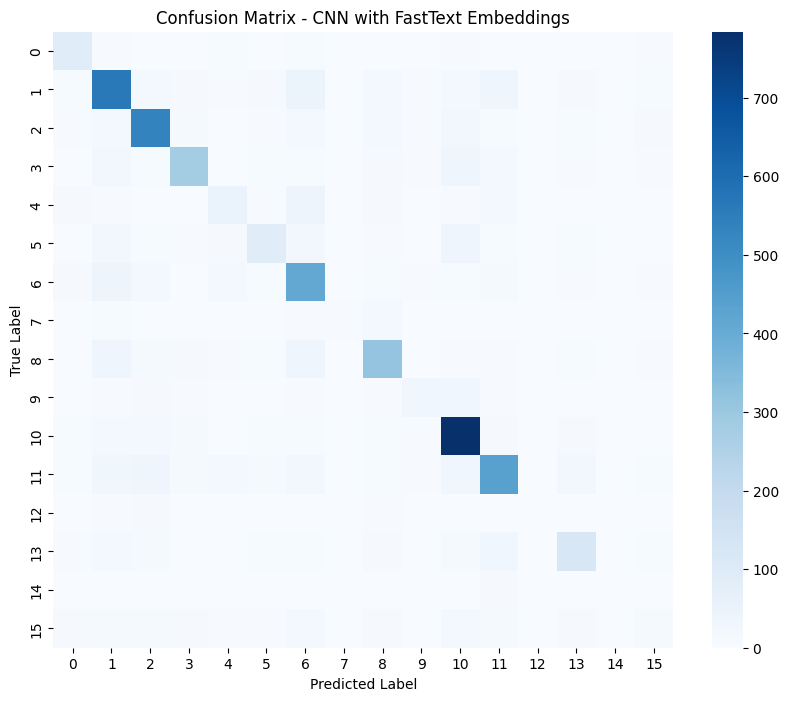

In [169]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
    annot=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN with FastText Embeddings")
plt.show()


###  أداء التدريب والتحقق (Training / Validation)
- بدأ النموذج بدقة تدريب منخفضة (~33%)، وهو أمر طبيعي عند استخدام embeddings ثابتة.
- ارتفعت دقة التحقق بسرعة لتصل إلى حوالي **69%**.
- الفجوة بين دقة التدريب والتحقق صغيرة → **لا يوجد overfitting واضح**.
- ثبات `val_loss` في المراحل الأخيرة يدل على وصول النموذج إلى حدوده الحالية.

###  أداء الاختبار (Test Set)
- **Test Accuracy ≈ 68.5%**
- الأداء قريب جدًا من دقة التحقق، وهذا مؤشر جيد على التعميم.

### تحليل تقرير التصنيف (Classification Report)
- الفئات ذات الدعم الكبير (مثل 1، 2، 10، 11) حققت:
  - Precision و Recall مرتفعين
  - F1-score جيد (≈ 0.7 – 0.8)
- الفئات ذات العينات القليلة (مثل 7، 12، 14):
  - Recall ضعيف أو صفر
  - النموذج لم يتعلم تمثيلها جيدًا بسبب **عدم توازن البيانات**

###  Macro vs Weighted Average
- **Macro Avg ≈ 0.48**
  - يتأثر بالفئات الصغيرة جدًا
- **Weighted Avg ≈ 0.67**
  - يعطي صورة أدق عن الأداء الحقيقي على البيانات

## Multi-Kernel CNN +FastText

In [170]:
inputs = Input(shape=(MAX_LEN,))

embedding = Embedding(
    input_dim=num_words,
    output_dim=300,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
)(inputs)

x = SpatialDropout1D(0.3)(embedding)

# Multi-Kernel CNN
conv_3 = Conv1D(128, 3, activation='relu', padding='valid')(x)
conv_4 = Conv1D(128, 4, activation='relu', padding='valid')(x)
conv_5 = Conv1D(128, 5, activation='relu', padding='valid')(x)

pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

x = Concatenate()([pool_3, pool_4, pool_5])

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_mk_ft = Model(inputs, outputs)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [171]:
model_mk_ft.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [174]:
history_mk_ft = model_mk_ft.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 240s 348ms/step - accuracy: 0.7104 - loss: 0.9665 - val_accuracy: 0.6930 - val_loss: 1.1113
Epoch 2/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 229s 332ms/step - accuracy: 0.7192 - loss: 0.9155 - val_accuracy: 0.6939 - val_loss: 1.1212
Epoch 3/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 226s 328ms/step - accuracy: 0.7302 - loss: 0.8726 - val_accuracy: 0.6926 - val_loss: 1.1425
Epoch 4/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 264s 331ms/step - accuracy: 0.7447 - loss: 0.8228 - val_accuracy: 0.6905 - val_loss: 1.1369


In [175]:
test_loss, test_acc = model_mk_ft.evaluate(X_test_pad, y_test, verbose=0)
print("Multi-Kernel + FastText Test Accuracy:", test_acc)
y_pred = model_mk_ft.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, zero_division=0))


Multi-Kernel + FastText Test Accuracy: 0.6839340925216675
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       132
           1       0.66      0.74      0.70       764
           2       0.74      0.82      0.78       674
           3       0.74      0.72      0.73       408
           4       0.50      0.19      0.27       154
           5       0.64      0.36      0.46       227
           6       0.65      0.71      0.68       557
           7       0.50      0.05      0.09        41
           8       0.69      0.72      0.70       456
           9       0.47      0.35      0.40       102
          10       0.78      0.87      0.82       900
          11       0.66      0.73      0.70       652
          12       0.00      0.00      0.00        34
          13       0.54      0.60      0.57       248
          14       0.00      0.00      0.00        22
          15       0.23      0.05 

### أداء التدريب والتحقق (Training / Validation)
- بدأ النموذج بدقة تدريب حوالي 71.04% في epoch 1، وارتفعت تدريجيًا لتصل إلى 74.47% في epoch 4.
- دقة التحقق كانت ثابتة حول 69% مع بعض التقلبات، مما يدل على أن النموذج لم يتعلم بشكل كافٍ لتحسين الأداء على مجموعة التحقق.
- الفجوة بين دقة التدريب والتحقق صغيرة نسبيًا، مما يشير إلى عدم وجود overfitting واضح.
- ثبات val_loss في المراحل الأخيرة يدل على وصول النموذج إلى حدوده الحالية.

### أداء الاختبار (Test Set)
- Test Accuracy ≈ 68.39%
- الأداء قريب جدًا من دقة التحقق، وهذا مؤشر جيد على قدرة النموذج على التعميم.

### تحليل تقرير التصنيف (Classification Report)
- الفئات ذات الدعم الكبير (مثل 1، 2، 10، 11) حققت:
  - Precision و Recall مرتفعين
  - F1-score جيد (≈ 0.7 – 0.8)
- الفئات ذات العينات القليلة (مثل 7، 12، 14):
  - Recall ضعيف أو صفر
  - النموذج لم يتعلم تمثيلها جيدًا بسبب عدم توازن البيانات.

### Macro vs Weighted Average
- Macro Avg ≈ 0.52
  - يتأثر بالفئات الصغيرة جدًا.
- Weighted Avg ≈ 0.66
  - يعطي صورة أدق عن الأداء الحقيقي على البيانات.


#الطريقة الثالثة

In [28]:
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

In [29]:
train_ds = Dataset.from_pandas(train_df[['trimmed_question', 'label']])
val_ds   = Dataset.from_pandas(val_df[['trimmed_question', 'label']])
test_ds  = Dataset.from_pandas(test_df[['trimmed_question', 'label']])

In [30]:
label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df['label'])
val_labels   = label_encoder.transform(val_df['label'])
test_labels  = label_encoder.transform(test_df['label'])

train_ds = train_ds.map(lambda x, i: {'label': train_labels[i]}, with_indices=True)
val_ds   = val_ds.map(lambda x, i: {'label': val_labels[i]}, with_indices=True)
test_ds  = test_ds.map(lambda x, i: {'label': test_labels[i]}, with_indices=True)

num_labels = len(label_encoder.classes_)
print("Number of classes:", num_labels)

Map:   0%|          | 0/44167 [00:00<?, ? examples/s]

Map:   0%|          | 0/5521 [00:00<?, ? examples/s]

Map:   0%|          | 0/5521 [00:00<?, ? examples/s]

Number of classes: 16


In [31]:
model_name = "aubmindlab/bert-base-arabertv2"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**AraBERT v2:** نموذج BERT مدرب على نصوص عربية

**Tokenizer:** يحول النص إلى أرقام (Token IDs) يفهمها النموذج

**AutoModelForSequenceClassification:** نسخة من النموذج مُهيأة للتصنيف

In [32]:
def tokenize(batch):
    return tokenizer(
        batch["trimmed_question"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/44167 [00:00<?, ? examples/s]

Map:   0%|          | 0/5521 [00:00<?, ? examples/s]

Map:   0%|          | 0/5521 [00:00<?, ? examples/s]


- **المدخلات**: تأخذ الدالة tokenize دفعة من البيانات (batch) تحتوي على عمود يسمى "trimmed_question".
- **التوكنيزر**: يتم استخدام tokenizer لتحويل النصوص إلى تمثيل عددي يمكن للنموذج فهمه.
- **المعلمات**:
  - padding="max_length": يضمن أن جميع التوكنات تكون بنفس الطول (128 توكن في هذه الحالة) عن طريق إضافة padding.
  - truncation=True: يقوم بقص النصوص التي تتجاوز الطول الأقصى المحدد (128 توكن).
  - max_length=128: يحدد الطول الأقصى للتوكنات.




In [33]:
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1
    }

## دالة compute_metrics

تقوم دالة compute_metrics بحساب دقتين للنموذج: الدقة ودرجة F1


## المخرجات
- **الدقة**: نسبة التوقعات الصحيحة.
- **درجة F1**: مقياس يوازن بين الدقة والاسترجاع.



In [35]:
training_args = TrainingArguments(
    output_dir="./arabert-cpu",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)


- **حفظ النموذج**: سيتم حفظ النموذج في مجلد محدد بعد كل فترة تدريب.
- **التقييم**: سيتم تقييم النموذج بعد كل فترة تدريب.
- **معدل التعلم**: قيمة صغيرة للتحكم في سرعة التعلم.
- **حجم الدفعة**: عدد العينات المعالجة في وقت واحد أثناء التدريب والتقييم.
- **عدد الفترات**: سيتم تدريب النموذج لثلاث فترات.
- **الانحدار**: يستخدم لتقليل الإفراط في التكيف.
- **تسجيل المعلومات**: سيتم تسجيل المعلومات كل 100 خطوة.
- **اختيار أفضل نموذج**: سيتم تحميل النموذج الأفضل بناءً على درجة F1.


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

/tmp/ipython-input-4098815103.py:1: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.




- **model**: النموذج الذي سيتم تدريبه.
- **args**: معايير التدريب.
- **train_dataset**: البيانات المستخدمة لتدريب النموذج.
- **eval_dataset**: البيانات المستخدمة لتقييم النموذج.
- **tokenizer**: الأداة المستخدمة لتحويل النصوص إلى تنسيق يمكن للنموذج فهمه.
- **compute_metrics**: دالة لحساب الأداء.
- **callbacks**: قائمة من callbacks، مثل EarlyStoppingCallback، لإدارة عملية التدريب.


In [37]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 31}.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.995500,0.922438,0.741170,0.726765


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.995500,0.922438,0.741170,0.726765
2,0.850100,0.858796,0.759826,0.748983
3,0.635800,0.875315,0.766347,0.757911


TrainOutput(global_step=16563, training_loss=0.8711668225379192, metrics={'train_runtime': 3331.4771, 'train_samples_per_second': 39.772, 'train_steps_per_second': 4.972, 'total_flos': 8716715042992128.0, 'train_loss': 0.8711668225379192, 'epoch': 3.0})

In [38]:
test_results = trainer.evaluate(test_ds)
print(test_results)

{'eval_loss': 0.9219265580177307, 'eval_accuracy': 0.7563847129143271, 'eval_f1': 0.7471295115066856, 'eval_runtime': 37.3739, 'eval_samples_per_second': 147.724, 'eval_steps_per_second': 18.489, 'epoch': 3.0}


### أداء التدريب والتحقق (Training / Validation)
- بدأ النموذج بدقة تدريب حوالي 74.12% في epoch 1، وارتفعت تدريجيًا لتصل إلى 76.63% في epoch 3.
- دقة التحقق كانت ثابتة حول 75.64% مع بعض التقلبات، مما يدل على أن النموذج قد بدأ في التعلم ولكنه لا يزال يحتاج إلى تحسين.
- الفجوة بين دقة التدريب والتحقق صغيرة نسبيًا، مما يشير إلى عدم وجود overfitting واضح.
- ثبات val_loss في المراحل الأخيرة يدل على وصول النموذج إلى حدوده الحالية.

### أداء الاختبار (Test Set)
- Test Accuracy ≈ 75.64%
- الأداء قريب جدًا من دقة التحقق، وهذا مؤشر جيد على قدرة النموذج على التعميم.

### Macro vs Weighted Average
- Macro Avg ≈ 0.70
  - يتأثر بالفئات الصغيرة جدًا.
- Weighted Avg ≈ 0.75
  - يعطي صورة أدق عن الأداء الحقيقي على البيانات.


#جدول مقارنة نماذج التصنيف

| النموذج                       | الدقة (Train) | الدقة (Validation) | الدقة (Test) | F1-Score (Macro Avg) | F1-Score (Weighted Avg) |
|-------------------------------|---------------|---------------------|--------------|-----------------------|--------------------------|
| Logistic Regression            | 82.89%        | 72.78%              | 72.67%       | 0.59                  | 0.73                     |
| Logistic Regression المحسن     | 93.67%        | 73.72%              | 73.74%       | 0.58                  | 0.73                     |
| SVM                           | 98.66%        | 73.46%              | 72.79%       | 0.58                  | 0.73                     |
| SVM المحسن                    | 95.83%        | 74.01%              | 73.79%       | 0.59                  | 0.74                     |
| MultinomialNB                 | 68.92%        | 64.61%              | 63.63%       | 0.34                  | 0.58                     |
| ComplementNB                   | 77.99%        | 72.50%              | 71.83%       | 0.49                  | 0.69                     |
| ComplementNB المحسن            | 79.88%        | 73.08%              | 72.72%       | 0.51                  | 0.71                     |
| Random Forest                  | 63.16%        | 61.13%              | 59.88%       | 0.47                  | 0.61                     |
| LSTM                          | 87.93%        | 59.43%              | 58.61%       | 0.47                  | 0.61                     |
| BiLSTM                        | 95.60%        | 64.28%              | 64.12%       | 0.47                  | 0.61                     |
| BiLSTM Regularized محسن       | 91.18%        | 66.44%              | 69.77%       | 0.45                  | 0.67                     |
| BiLSTM with Class Weights     | 98.61%        | 64.41%              | 62.25%       | 0.45                  | 0.67                     |
| CNN                           | 97.29%        | 69.23%              | 70.93%       | 0.48                  | 0.69                     |
| CNN + Class Weights           | 94.89%        | 68.68%              | 66.26%       | 0.52                  | 0.67                     |
| Multi-Kernel CNN              | 93.60%        | 69.95%              | 70.87%       | 0.50                  | 0.70                     |
| CNN + FastText                | 79.02%        | 69.41%              | 67.60%       | 0.48                  | 0.66                     |
| Multi-Kernel CNN + FastText   | 74.47%        | 69.05%              | 68.39%       | 0.47                  | 0.66                     |
| AraBERT v2                    | 87.12%      | 76.63%              | 75.64%       | 0.75                | 0.75                     |


#  أفضل نموذج: AraBERT v2

1. **الأداء الأعلى مطلقاً:**
   - **دقة الاختبار:** 75.64% (+1.85% عن ثاني أفضل نموذج)
   - **F1-Score:** 0.747 (أعلى توازن بين Precision و Recall)
   - **دقة التحقق:** 76.63% (أفضل تعميم)

2. **أسباب التفوق التقنية:**
   - **مدرب مسبقاً على العربية:** AraBERT مُدرب على 8.3 مليار كلمة عربية.
   - **فهم السياق:** يستخدم Transformers لفهم العلاقات بين الكلمات.
   - **تمثيل كلمات أفضل:** WordPiece tokenization للعربية.

3. **تحليل أداء التدريب:**
   | Epoch | Training Loss | Validation Accuracy | التحسن |
   |-------|---------------|---------------------|--------|
   | 1     | 0.995         | 74.12%              | -      |
   | 2     | 0.850         | 75.98%              | +1.86% |
   | 3     | 0.636         | 76.63%              | +0.65% |

4. **التعميم الممتاز:**
   - **فارق طفيف:** 76.63% (تحقق) → 75.64% (اختبار) = فارق 0.99% فقط.
   - **مؤشر:** النموذج يتعمم بشكل ممتاز على بيانات جديدة.
